## In this Notebook, we will create a basic Q&A chain and Agent over a SQL database

### Architecture

At a high-level, the steps of any SQL chain and agent are:

- `Convert question to SQL query using the LLM Model.`
- `Execute the SQL query.`
- `getting the Model to respond to user input using the query results.`

In [1]:
from langchain.utilities import SQLDatabase
from langchain.chat_models import ChatOpenAI
from langchain.chains import create_sql_query_chain
from langchain_openai import ChatOpenAI


In [2]:
llm = ChatOpenAI(temperature=0)

In [3]:
host = '0.0.0.0'
port = '5432'
username = 'odin'
password = 'odin'
db_name = 'analytics'
postgres_connection = f"postgresql://{username}:{password}@{host}:{port}/{db_name}"

db = SQLDatabase.from_uri(postgres_connection, sample_rows_in_table_info=2)
chain = create_sql_query_chain(llm, db)

In [4]:
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT count(*) FROM customer LIMIT 10;")

postgresql
['customer', 'sale']


'[(1000,)]'

In [5]:
response = chain.invoke({"question": "How many employees are there"})
response

'SELECT COUNT(*) AS total_employees FROM customer;'

In [6]:
db.run(response)

'[(1000,)]'

In [7]:
response = chain.invoke({"question": "How many customers are from Bronx"})
print(response)
print(db.run(response))

SELECT COUNT(*) 
FROM customer 
WHERE city = 'Bronx' 
LIMIT 5;
[(2,)]


In [8]:
response = chain.invoke({"question": "Which state are customers most from?"})
print(response)
print(db.run(response))

SELECT "state_", COUNT(*) AS state_count
FROM customer
GROUP BY "state_"
ORDER BY state_count DESC
LIMIT 1;
[('CA', 79)]


In [14]:
response = chain.invoke({"question": "Give me the top 5 customers who paid the highest shipping charges"})
print(response)

res = db.run(response)

SELECT c.customerid, c.firstname, c.lastname, s.shipping
FROM customer c
JOIN sale s ON c.customerid = s.customerid
ORDER BY s.shipping DESC
LIMIT 5;


In [19]:
class Payment:
    id: int
    name: str
    surname: str
    value: float

    def __init__(
            self,
            id: int,
            name: str,
            surname: str,
            value: float) -> None:
        self.id = id
        self.name = name
        self.surname = surname
        self.value = value

    @staticmethod
    def from_tuple(data: tuple):
        return Payment(
            id = data[0],
            name = data[1],
            surname = data[2],
            value = data[3],
        )
    
    def __str__(self) -> str:
        return f"""
            id: {self.id}
            name: {self.name}
            surname: {self.surname}
            value: {self.value}
        """
    
    def to_dict(self) -> dict:
        return {
            'id': self.id,
            'name': self.name,
            'surname': self.surname,
            'value': self.value
        }
    

In [21]:
import ast

payments = []

for item in ast.literal_eval(res):
    payments.append(Payment.from_tuple(data=item))

    print(payments[-1])


            id: 1096
            name: Meliha
            surname: Handzic
            value: 59.37
        

            id: 1950
            name: Jack
            surname: Freund
            value: 54.45
        

            id: 724
            name: Epaminondas
            surname: Kapetanios
            value: 54.41
        

            id: 3979
            name: Glen
            surname: Quintana
            value: 54.39
        

            id: 1385
            name: Peter
            surname: Pille
            value: 52.88
        


In [23]:
import pandas as pd

users_dicts = [item.to_dict() for item in payments]

df = pd.DataFrame(users_dicts)

print(df)

     id         name     surname  value
0  1096       Meliha     Handzic  59.37
1  1950         Jack      Freund  54.45
2   724  Epaminondas  Kapetanios  54.41
3  3979         Glen    Quintana  54.39
4  1385        Peter       Pille  52.88


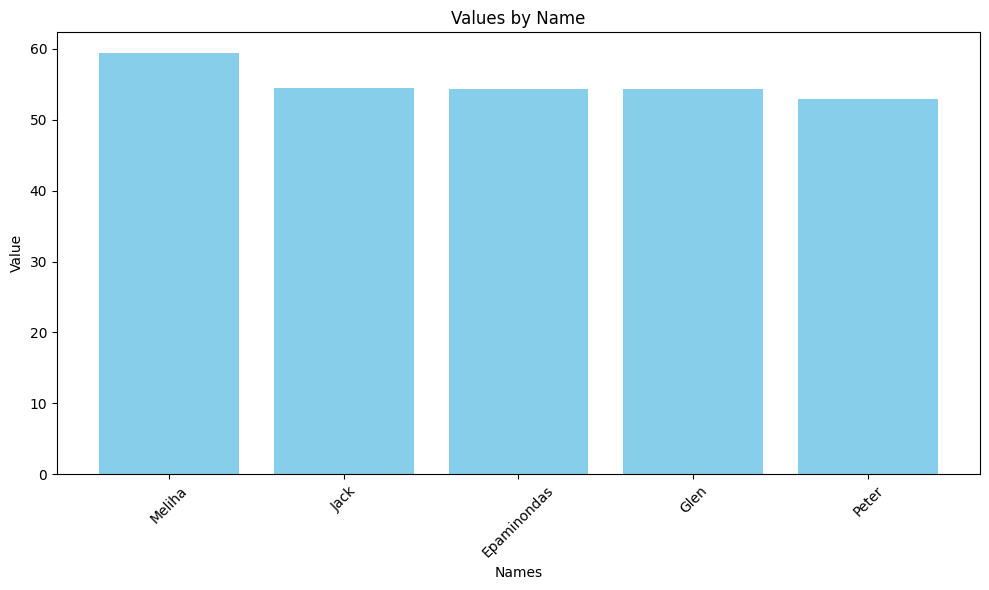

In [56]:
import matplotlib.pyplot as plt 

# Extracting 'name' and 'value' columns
names = df['name']
values = df['value']

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(names, values, color='skyblue')
plt.xlabel('Names')
plt.ylabel('Value')
plt.title('Values by Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
